In [1]:
#%% Import modules
import pickle
import math
import random
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
from trajectory import SRPActivator, Solver

filename = "decent.pkl"
with open(filename, "rb") as file:
    sol = pickle.load(file)

filename = "solution.pkl"
with open(filename, "rb") as file:
    solution = pickle.load(file)


12.586449986391997 2290.2390445866486
12.749629771593634 4810.377605811393
13.118448862495075 10688.58849099018
13.338164213125063 17043.979977405106
13.391524678081431 19036.320069609133
13.497041706208368 23748.857241103007
13.620953026120713 30705.480198099685
13.704450871990266 37693.52646780746
13.735554284070203 44370.90705145997
13.786192959888899 57851.406337552355
13.826781590574544 71502.07579631271
13.844568754102397 78411.19823216023
13.889852214965675 99232.56201262398
13.99445209767032 170275.87715108256
14.059407452474227 242681.87414670116


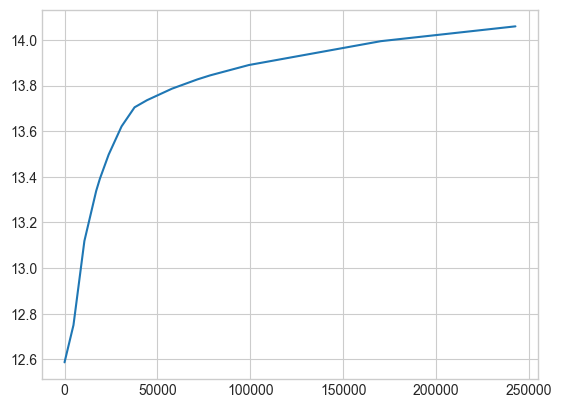

In [2]:
line_points = list()
v_crit = 4000
for name, dir in sol.__results_dict__.items():
    Ma = np.array(dir.Ma)
    Re = np.array(dir.Re)
    v = dir.V
    v0 = v[v < v_crit][0]
    v1 = v[v > v_crit][-1]
    Ma0 = Ma[v < v_crit][0]
    Ma1 = Ma[v > v_crit][-1]
    Map = (v_crit - v0)/(v1-v0) * (Ma1-Ma0) + Ma0
    Re0 = Re[v < v_crit][0]
    Re1 = Re[v > v_crit][-1]
    Rep = (v_crit - v0)/(v1-v0) * (Re1-Re0) + Re0
    print(Map,Rep)
    line_points.append([Rep,Map])
line_points = np.array(line_points)
line_points[0,0] = 0
plt.plot(line_points[:,0], line_points[:,1])

In [4]:
# random points
points = list()
out_list = list()
for name, dir in solution.__results_dict__.items():
    Ma = dir.Ma
    Re = dir.Re
    P = dir.P
    T = dir.T
    V = dir.V
    r = dir.r
    set = np.array([np.array(Ma), np.array(Re)/1000]).T
    tset = np.array([Ma, Re, P, T, V, r]).T
    f = 0
    while 1:
        i = int(random.randint(0, len(set)-10))
        val = set[i]
        kn = val[0] / (1000*val[1]) * 1.48
        if not (math.isnan(val[1]) or kn > 0.005 or val[0] < 2):
            dis = 1e5
            for out in out_list:
                ndis = np.linalg.norm(val - out)
                if ndis < dis:
                    dis = ndis
            if dis > 1.7:
                points.append([*tset[i], float(name)])
                out_list.append(val)
                if f:
                    break
                f = 1

points = np.array(points)
#np.save('dataset.npy', points)

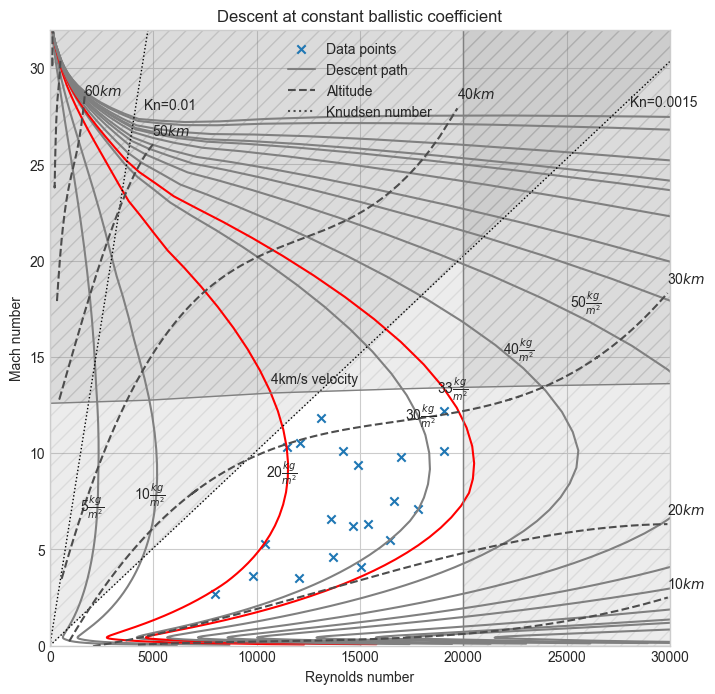

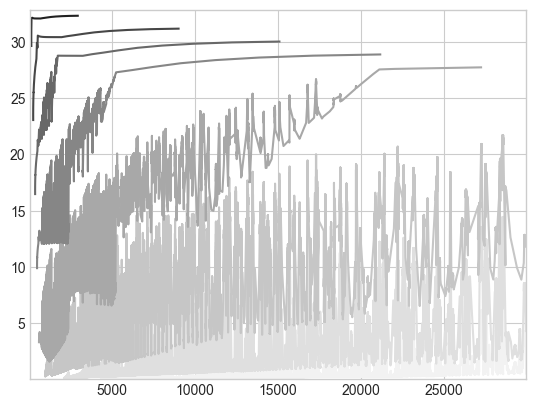

In [4]:
# -------------------------- Plotting the trajectory ---------------------------
fig, ax = plt.subplots(figsize=(8,8))

for name, dir in sol.__results_dict__.items():
    c = 'gray'
    if name == '20' or name == '33':
        c = 'red'
    ax.plot(dir.Re, dir.Ma, c, )
    for Re, Ma in zip(dir.Re, dir.Ma):
        if abs(Ma - (Re/8000)**2 -3.5) < 3 and Ma < 30 and Re < 30000:
    #        if i == 118:  # Place label for every 10th data point
            ax.text(Re-200, Ma+1, f'{name}'+r'$\frac{kg}{m^2}$', horizontalalignment='center', verticalalignment='center')
            break

points = np.load('casepoints.npy')
ax.scatter(points[:,1], points[:,0], marker='x', label= 'Data points')
#ax.scatter([7500],[5],marker='x', color='C2')

# Limits
for Kn in [0.01, 0.0015]:
    Re_kn = np.linspace(0, 35000, 1000)
    Ma_kn = Re_kn * Kn / np.sqrt(1.4*np.pi/2)

    ax.text(Re_kn[Ma_kn<28][-1]+400, Ma_kn[Ma_kn<28][-1], f'Kn={Kn}')
    ax.plot(Re_kn, Ma_kn, ':k', linewidth=1)

ax.fill_between(Re_kn, Ma_kn, np.ones_like(Re_kn)*50, color='gray', hatch='//', alpha = 0.15)

ax.plot([20000,20000], [0,40], c,linewidth=1)
ax.fill_between([20000,40000], [0,0], [40,40], color='gray', hatch='//', alpha = 0.15)


ax.text(line_points[2,0],line_points[2,1]+0.5, '4km/s velocity')
ax.plot(line_points[:,0], line_points[:,1], c,linewidth=1)
ax.fill_between(line_points[:,0], line_points[:,1], np.ones_like(line_points[:,1])*50, color='gray', hatch='//', alpha = 0.15)

ax.set_ylim(0,34)
ax.set_xlim(0, 30000)
ax.set_xlabel(f'Reynolds number')
ax.set_ylabel(f'Mach number')
ax.set_title(r'Descent at constant ballistic coefficient', fontsize=12)

fig2, ax2, = plt.subplots()
Re = list()
Ma = list()
Alt = list()
for name, dir in sol.__results_dict__.items():
    for re, ma, alt in zip( dir.Re, dir.Ma, dir.r ):
        if re < 30000 and ma < 35 and alt < 86000:
            Re.append(re)
            Ma.append(ma)
            Alt.append(alt/1000)

contour_collections = ax2.tricontour(Re, Ma, Alt, levels = 8)
contour_paths = contour_collections.collections
contour_levels = contour_collections.levels
light_blue = (0.3, 0.3, 0.3)
for name,  path in zip(contour_levels, contour_paths):
    vertices = path.get_paths()
    for vortex in vertices:
        x = vortex.vertices[:-20, 0]
        y = vortex.vertices[:-20, 1]
        coefficients = np.polyfit(x, y, 3)
        fitted_y = np.polyval(coefficients, x)
        ax.plot(x,fitted_y, '--', c=light_blue)
        if x[-10] < 35000 and fitted_y[-10] < 30:
            ax.text(x[-10], fitted_y[-10]+0.5, f'{name:.0f}$km$')

ax.plot([],[],c = c, label='Descent path')
ax.plot([],[],'--',c = light_blue, label='Altitude')
ax.plot([],[],':',c = light_blue, label='Knudsen number')

ax.set_ylim(0,32)
ax.legend()


Kn = 0.01 50777.115048332
Kn = 
Kn = 0.01 51782.89772230946
Kn = 


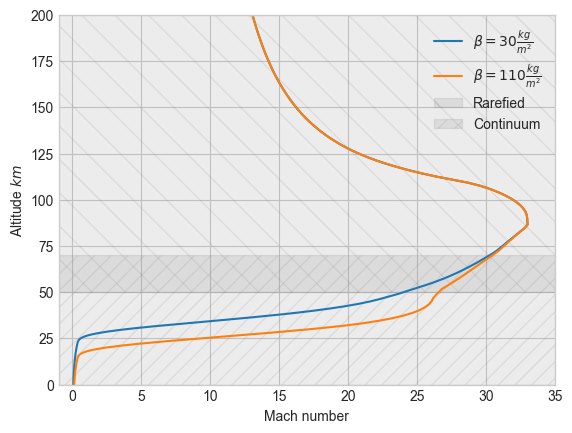

In [8]:
fig, ax = plt.subplots()
for i in ['30', '110']:
    dir =  sol.__results_dict__[i]
    Ma = np.array(dir.Ma)
    Re = np.array(dir.Re)
    Kn = Ma/Re * np.sqrt(1.4*np.pi/2)
    print('Kn = 0.01',dir.r[Kn<0.01][0])
    print('Kn = ')
    ax.plot(dir.Ma, dir.r/1000,label = r'$\beta =' +f'{i} '+ r'\frac{kg}{m^2}$')
ax.fill_between([-5,40],[50,50],[250,250], color='gray', alpha = 0.15, hatch='\\',label='Rarefied')
ax.fill_between([-5,40],[0,0],[70,70], color='gray', alpha = 0.15, hatch='//',label='Continuum')    
ax.set_ylim(0,200)
ax.set_ylabel('Altitude $km$')
ax.set_xlabel('Mach number')
ax.set_xlim(-1,35)
ax.legend()


In [4]:
# ---------------------------- Making case files
for i, point in enumerate(points):
    # Assumes a 4m domain is used an L = 1m
    [Ma, Re, P, T, V, r, name] = point
    p = 8
    cells = int(Re/5 * 2**(3-p))
    cells = cells + 16 - cells%16
    while cells < 64:
        cells *= 2
        p -= 1


    l = 4
    lh = l * 2**(1-p) / cells
    Reh = Re * lh

    
    Cr = 0.3
    dt = Cr*lh/V
    t_end = int( (1.5/(V*dt)) / 1000 + 0.5) * 1000

    # init sizing Run 50 times with 5 levels and Cr = 2
    p_init = 5
    Cr_init = 3
    lh_init = l * 2**(1-p_init) / cells
    dt_init = Cr_init * lh_init/V
    steps = int( (200 / (V*dt_init)) / 1000 + 0.5) * 1000

    print(f'Case: {i}')
    print(f'Ma: {Ma:.2f}\t\tReynolds: {Re:.0f}\t\tVelocity: {V:.0f} m/s\t\tPressure: {P:.0f} Pa\t\tTemp: {T:.0f} K\t\tAltitude: {r/1000:.0f} km')
    print(f'Cells: {cells}\t\tLevels: {p} \t \tMin cell length: {lh*1000:.2f}mm \tRe_h: {Reh:.1f}\t\tTimestep: {dt:.2e} s\tSteps: {t_end:d}')
    print(f'Init_steps: {steps}\tdt_init: {dt_init:.1e}')
    try:
        os.makedirs(f'Cases_files/C{i}')
    except:
        pass

    # input_file
    with open(f'Cases_files/C{i}/input_file', 'w') as file:
        print(f'{Ma:.1f} {Re:.0f} {T:.0f} 400 {P:.0f} 0.1', file=file)
        print(f'\n# ------------------------ Case {i}, using beta = {name} kg/m^2 ------------------------ ', file=file)
        print(f'#Ma: {Ma:.2f}\t\tReynolds: {Re:.0f}\t\tVelocity: {V:.0f} m/s\t\tPressure: {P:.0f} Pa\t\tTemp: {T:.0f} K\t\tAltitude: {r/1000:.0f} km',file=file)
        print(f'#Cells: {cells}\t\tLevels: {p} \t \tMin cell length: {lh*1000:.2f}mm \tRe_h: {Reh:.1f}\t\tTimestep: {dt:.2e} s\tSteps: {t_end:d}',file=file)

    filename = f'Cases_files/C{i}/input_init'
    shutil.copy('Cases_files/input_init', filename)

    with open(filename, "r") as file:
        content = file.read()
        content = content.replace("placeholder_nx", f'{cells}')
        content = content.replace("placeholder_ny", f'{int(cells/2)}')
        content = content.replace("placeholder_nsteps", f'{steps}')
        content = content.replace("placeholder_time-step", f'{dt_init:.2e}')
        
    with open(filename, "w") as file:
        file.write(content)


    filename = f'Cases_files/C{i}/input_restart'
    shutil.copy('Cases_files/input_restart', filename)
    with open(filename, "r") as file:
        content = file.read()
        content = content.replace("placeholder_nx", f'{cells}')
        content = content.replace("placeholder_ny", f'{int(cells/2)}')
        content = content.replace("placeholder_nsteps", f'{t_end}')
        content = content.replace("placeholder_time-step", f'{dt:.2e}')
        content = content.replace("placeholder_nlevs", f'{p}')
        
        
    with open(filename, "w") as file:
        file.write(content)




Case: 0
Ma: 4.60		Reynolds: 9861		Velocity: 1354 m/s		Pressure: 729 Pa		Temp: 232 K		Altitude: 33 km
Cells: 64		Levels: 8 	 	Min cell length: 0.49mm 	Re_h: 4.8		Timestep: 1.08e-07 s	Steps: 10000
Init_steps: 17000	dt_init: 8.7e-06
Case: 1
Ma: 10.30		Reynolds: 11457		Velocity: 3103 m/s		Pressure: 404 Pa		Temp: 243 K		Altitude: 38 km
Cells: 80		Levels: 8 	 	Min cell length: 0.39mm 	Re_h: 4.5		Timestep: 3.78e-08 s	Steps: 13000
Init_steps: 21000	dt_init: 3.0e-06
Case: 2
Ma: 2.66		Reynolds: 8001		Velocity: 774 m/s		Pressure: 1001 Pa		Temp: 228 K		Altitude: 31 km
Cells: 64		Levels: 8 	 	Min cell length: 0.49mm 	Re_h: 3.9		Timestep: 1.89e-07 s	Steps: 10000
Init_steps: 17000	dt_init: 1.5e-05
Case: 3
Ma: 7.45		Reynolds: 11967		Velocity: 2214 m/s		Pressure: 563 Pa		Temp: 237 K		Altitude: 35 km
Cells: 80		Levels: 8 	 	Min cell length: 0.39mm 	Re_h: 4.7		Timestep: 5.29e-08 s	Steps: 13000
Init_steps: 21000	dt_init: 4.2e-06
Case: 4
Ma: 15.91		Reynolds: 10378		Velocity: 4891 m/s		Pressure: 249 Pa		Tem

In [2]:
# ---------------------------- Latin square randomisation -------------------------------
n = 20; m = 28
nl = np.arange(n)
ml = np.arange(m)
square =np.ones((n,m),dtype=bool)
res = np.zeros((n,m))
l = list()
i = 1
square[14,20] = square[8,3] = square[1,26] = square[4,16] = square[0,5] = square[14,1] = square[14,22] = square[11,20] = False
square[7,16] = square[5,14] = square[15,25] = square[17,5] = square[14,12] = square[19,10] = square[11,27] = square[3,8] =False
square[1,5] = square[10,24] = square[12,21] = square[14,25] = square[16,3] = square[1,2] = square[3,25] = False
while square.sum():
    nl = np.arange(n)
    linea = np.ones((n),dtype=bool)
    lineb = np.ones((m),dtype=bool)
    while linea.sum():
        a = np.random.choice(nl[linea])
        linea[a] = False
        line = lineb&square[a]
        if line.sum():
            b = np.random.choice(ml[line])
            lineb[b] = False
            square[a,b] = False
            res[a,b] = i
            l.append([b,a])

    i += 1
        #print(line, a, b)

#print(res)
with open('new_order', 'w') as file:
    for item in l:
        file.write(f'{item[0]} {item[1]}\n')
